# GETTING THE DATA

The code in the following cell is generated with ChatGpt to seperate each character into individual images in order to generate the dataset.

In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the image
image = cv2.imread('nushu_fonts_ægte.png')

# Define the number of rows and columns for the grid
rows = 26
cols = 16

# Calculate the dimensions of each smaller image
height, width, _ = image.shape
small_height = height // rows
small_width = width // cols

# Split the image into smaller images
small_images = []
for r in range(rows):
    for c in range(cols):
        start_row = r * small_height
        end_row = start_row + small_height
        start_col = c * small_width
        end_col = start_col + small_width

        small_image = image[start_row:end_row, start_col:end_col]
        small_images.append(small_image)

# Create a folder to save the smaller images
folder_name = 'small_images'
os.makedirs(folder_name, exist_ok=True)

# Save the smaller images in the folder
for i, small_image in enumerate(small_images):
    filename = os.path.join(folder_name, f'small_image_{i}.jpg')
    cv2.imwrite(filename, small_image)

NameError: ignored

# DCGAN


In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
# set the core to cpu
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cuda'
# device = 'mps'
#device = torch.device('cpu')
#device = 'gpu'
#torch.set_default_device(device)

In [ ]:
# this is the size of the output image
#image_size =  512 if torch.cuda.is_available() else 128  # use small size if no GPU

## LOAD THE DATA IN USING GOOGLE DRIVE
For the next cells I followed this guide: https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

In [ ]:
# connect to google drive in order to access zip file with data
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Import the libraries
import zipfile
import os
from PIL import Image

# get the data!
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/data/nushu_final.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()


In [ ]:
# put data in variable
data = os.listdir('/tmp/nushu_final64/')

In [ ]:
print(len(data))
print(type(data))

1588
<class 'list'>


In [ ]:
# how to tranform data to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

 #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

In [ ]:
# Convert the images to tensors
tensor_data = []       # hold all the tensors
for image_path in data:
    image = Image.open('/tmp/nushu_final64/' + image_path)
    tensor = transform(image)        # apply transform to each image -> meaning convert to tensor
    tensor_data.append(tensor)

# Concatenate the tensors into a single tensor
data_tensor = torch.stack(tensor_data)

In [ ]:
print(type(data_tensor))
print(len(data_tensor))

<class 'torch.Tensor'>
1588


In [ ]:
# split data into test and train
# Split ratio for train and test
train_ratio = 0.85
test_ratio = 0.15

# shuffle the data
random.shuffle(data_tensor)

# Split the dataset into train and test subsets
train_size = int(train_ratio * len(data_tensor))
train_data = data_tensor[:train_size]
test_data = data_tensor[train_size:]

In [ ]:
## look at the data
print(len(train_data))
print(len(test_data))
print(type(train_data))
print(type(test_data))

1349
239
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(len(data_tensor))
print(type(data_tensor))

1588
<class 'torch.Tensor'>


In [ ]:
# convert list to numpy array
#data = np.array(data)

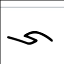

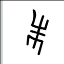

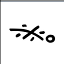

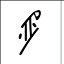

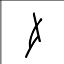

In [ ]:
# show sample images

# Path to the folder containing the images
folder_path = '/tmp/nushu_final64/'

# Set the desired width and height for displaying
desired_width = 64
desired_height = 64

# Display the first five images with resizing
for i in range(5):
    image_path = folder_path + data[i]
    image = Image.open(image_path)
    resized_image = image.resize((desired_width, desired_height))
    resized_image.show()

## SETTING UP INFORMATION FOR THE MODEL AND THE TRAINING AND TEST DATA

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [ ]:
# THIS IS PARAMETERS FOR THE MODEL

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
image_size = 64

# Number of channels in the training images. For color images this is 3 - is is only black and white but the data still holds 3 color channels
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Size of feature maps in generator
ngf = 12

# Size of feature maps in discriminator
ndf = 12

# Number of training epochs
num_epochs = 60

# Learning rate for optimizers
lr = 0.000002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cpu")
#tensor = torch.tensor([1, 2, 3])
#tensor.to(device)  # Moves the tensor to the device


## PREPARE THE DATA FOR TRAINING

Most of the code in the following cells are from this tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
# load in the data
#train_dataloader = torch.utils.data.DataLoader(train_data,
 #                                              batch_size=batch_size,
  #                                             shuffle=True,
   #                                            num_workers=workers)
#test_dataloader = torch.utils.data.DataLoader(test_data,
 #                                             batch_size=batch_size,
  #                                            shuffle=False,
   #                                           num_workers=workers)
train_dataloader = torch.utils.data.DataLoader(data_tensor,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)

In [ ]:
print(test_data.size())
print(train_data.size())
print((data_tensor.size()))

torch.Size([239, 3, 64, 64])
torch.Size([1349, 3, 64, 64])
torch.Size([1588, 3, 64, 64])


## SETTING UP THE MODEL

From here:  https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html   & here: https://towardsdatascience.com/how-to-build-a-dcgan-with-pytorch-31bfbf2ad96a

In [ ]:
# GET THE WEIGHTS FOR THE MODEL
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# CREATE GENERATOR
# Generator Code

class Generator(nn.Module):
    def __init__(self, nz, ngpu, nc):   # adding nz, nc
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# add noise vector to generator
#fake_images = Generator(noise)

In [ ]:
# APPLY WEIGHTS TO GENERATOR
# Create the generator
netG = Generator(nz,ngpu,nc).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 96, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# CREATE DISCRIMINATOR
class Discriminator(nn.Module):
    def __init__(self, nz, ngpu, nc):      # adding nz, nc
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# APPLY WEIGHTS TO DISCRIMINATOR
# Create the Discriminator
netD = Discriminator(nz,ngpu,nc).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(96, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# SET LOOS FUNCTION
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# got this error: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
# have a look at the input and target

print(train_data.size())

# change input size of train data
# Reshape train_data tensor
#train_data = train_data.permute(0, 3, 1, 2)  # Reshape to [batch_size, 3, 64, 64]
#train_data = train_data.unsqueeze(2).repeat(1, 1, nz, 1, 1)  # Repeat along the noise channel dimension

torch.Size([1349, 3, 64, 64])


In [ ]:
# kept getting this error: expected 4D input (got 3D input), even though the train_data and the noise vector was the same size, until I realised that it was the real_cpu
# look at the data
print(real_cpu.size())
#real_cpu = real_cpu.unsqueeze(0)
print(fixed_noise.size())

torch.Size([1, 3, 64, 64])
torch.Size([32, 10, 1, 1])


In [ ]:
# TRAINING LOOP

# Training Loop

# Lists to keep track of progress
img_list = []      # this hold generated images
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = train_data[0].to(device)     # unsqueezing here to make sure that real_cpu is not overwritten
        real_cpu = real_cpu.unsqueeze(0)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        # issue was with this line - first conv layer expects ngf*8 therefore noise vector should be 10
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):    # changing from 500 to 100 to save more generated images
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/60][0/50]	Loss_D: 1.0951	Loss_G: 0.7096	D(x): 0.6653	D(G(z)): 0.4972 / 0.4919
[1/60][0/50]	Loss_D: 1.1483	Loss_G: 0.5287	D(x): 0.7796	D(G(z)): 0.5931 / 0.5894
[2/60][0/50]	Loss_D: 0.7129	Loss_G: 0.8818	D(x): 0.8406	D(G(z)): 0.4168 / 0.4140
[3/60][0/50]	Loss_D: 0.7170	Loss_G: 0.8224	D(x): 0.8766	D(G(z)): 0.4430 / 0.4394
[4/60][0/50]	Loss_D: 0.6550	Loss_G: 0.8704	D(x): 0.8992	D(G(z)): 0.4223 / 0.4188
[5/60][0/50]	Loss_D: 0.9390	Loss_G: 0.5648	D(x): 0.9144	D(G(z)): 0.5724 / 0.5685
[6/60][0/50]	Loss_D: 0.6618	Loss_G: 0.8235	D(x): 0.9256	D(G(z)): 0.4426 / 0.4389
[7/60][0/50]	Loss_D: 0.5278	Loss_G: 1.0061	D(x): 0.9339	D(G(z)): 0.3683 / 0.3656
[8/60][0/50]	Loss_D: 0.6295	Loss_G: 0.8447	D(x): 0.9403	D(G(z)): 0.4333 / 0.4297
[9/60][0/50]	Loss_D: 0.9085	Loss_G: 0.5647	D(x): 0.9454	D(G(z)): 0.5736 / 0.5685
[10/60][0/50]	Loss_D: 0.2954	Loss_G: 1.5378	D(x): 0.9495	D(G(z)): 0.2161 / 0.2148
[11/60][0/50]	Loss_D: 0.5761	Loss_G: 0.8992	D(x): 0.9532	D(G(z)): 0.4103 / 0.4069


The D(x) indicates how confident the discriminator is when given fake data - closer to 1 is closer to a 100 percent

The D(G(z)) indicates how confident the discriminator is when given real - closer to 0 is closer to a 100 percent confident.

## LOOK AT THE GENERATED DATA

In [ ]:
# look at the generated data
print(type(img_list))
print(len(img_list))
print(img_list[:2])

<class 'list'>
31
[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4856,  ..., 0.4872, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.4794,  ..., 0.4863, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4922,  ..., 0.4663, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5058,  ..., 0.5014, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4844,  ...,

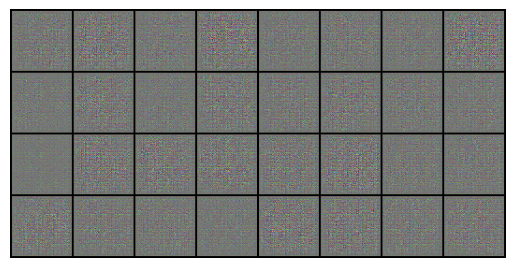

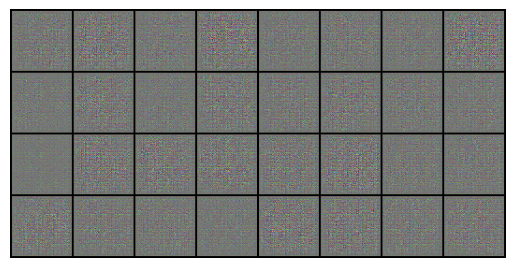

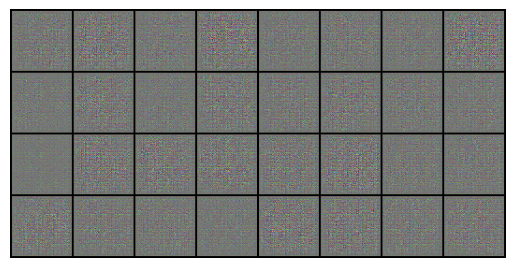

In [ ]:
# show the images
images = []     # hold converted images

# iterate over the generated tensors
for i, tensor in enumerate(img_list):
  tensor = img_list[i]
  tensor = transforms.ToPILImage()(tensor)     # transofrm to image
  images.append(tensor)

for image in images[:3]:    # show the first 3 images
  plt.imshow(tensor)
  plt.axis('off')
  plt.show()

# GENERATE

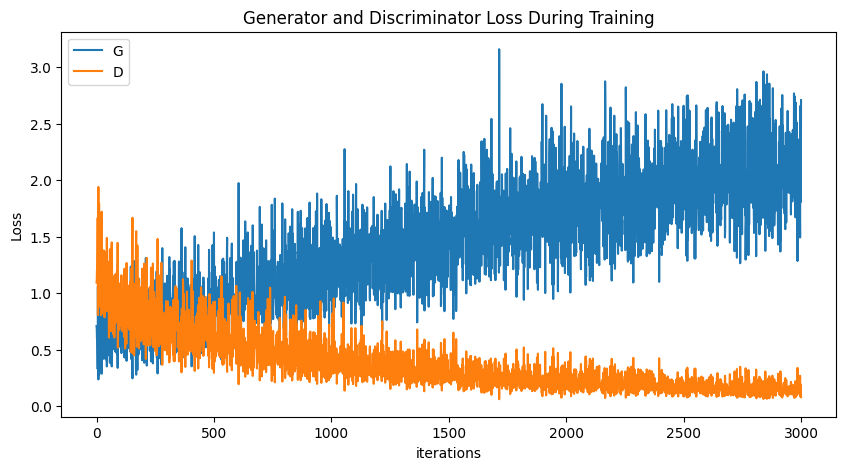

In [ ]:
# plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnissmation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
import imageio
import glob
# this code for animation is from the class notebook week 5 dcgan
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

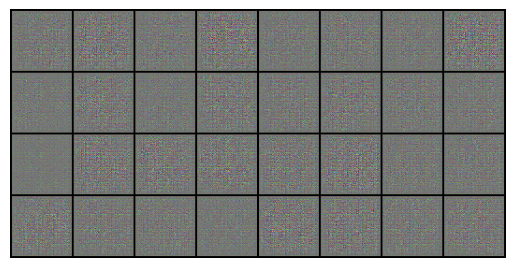

In [ ]:
# THIS CODE IS GENERATED IN CORPORATION WITH CHATGPT
# taking the img_list with generated images and using them to interpolate between

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Convert tensors to PIL images
pil_images = [transforms.ToPILImage()(img) for img in img_list]

# Create the animation
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in pil_images]
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)

# Save the animation
ani.save("gan_animation.gif", writer="pillow")
